<a href="https://colab.research.google.com/github/cdr6934/AcademicNotes/blob/master/HCA_Coding_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HCA Coding Challenge
Christopher Ried 
2/25/2020

In [0]:
import pandas as pd
import numpy as np 
import datetime as dt
import matplotlib.pyplot as plt

In [0]:
# Used to import data from drive to do analysis
from google.colab import drive
drive.mount('/content/drive')


# Pandas options to ensure better control 
pd.options.mode.use_inf_as_na = True

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Import data 
diabetes_ds = pd.read_csv('drive/My Drive/HCA Coding/diabetes_data.csv')


# Part 1: Data Analysis and Exploration 


Applied a few  transformations for the exercises to ensure the data will provide accurate information about the dataset. Using the IDs mapping append, I replaced some of the ids with null values to ensure to account for missing values within the dataset that might have a label but did not have any significance to the dataset directly. Now it can be inferred that a higher rate of nulls is due to a process improvement opportunity or deviation from standard procedure. 

In [0]:
# Replaced ? with a NaN 
diabetes_ds = diabetes_ds.replace('?',np.NaN)

diabetes_ds['admission_type_id']= diabetes_ds['admission_type_id'].replace(6,np.NaN)
diabetes_ds['discharge_disposition_id'] = diabetes_ds['discharge_disposition_id'].replace([18,25,26],np.NaN)
diabetes_ds['admission_source_id'] = diabetes_ds['admission_source_id'].replace([9,15,17],np.NaN)

# Add a flag for readmissions to easily identify the objective for the model 
diabetes_ds["Readmissions"] = diabetes_ds["readmitted"].apply(lambda x: 1 if x == '<30' else 0)

## 1. How many rows and columns are in the dataset?

In [0]:
print(diabetes_ds.shape[0], "rows and", str(diabetes_ds.shape[1]), "columns")


101766 rows and 51 columns


## 2. How many men are represented in the data versus women?



In [0]:
diabetes_ds.groupby(by='gender')['gender'].count()

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

There are 47,055 (53.7%) male 54,708 (46.2%) female and 3 unknown or invalid patients. 


## 3. What percent of the patients are African American?






In [0]:
diabetes_ds.groupby(by='race')['race'].count().transform(lambda x: x/x.sum())

race
AfricanAmerican    0.193079
Asian              0.006443
Caucasian          0.764868
Hispanic           0.020474
Other              0.015137
Name: race, dtype: float64

**There are 18.87% African American patients in the dataset.**

#4. What is the approximate average age of female patients in the dataset? Of male patients?

In [0]:
now = pd.to_datetime('now')
diabetes_ds['birth_date'] = pd.to_datetime(diabetes_ds['birth_date'], errors='coerce')
diabetes_ds['age'] = (now-diabetes_ds['birth_date']).astype('<m8[Y]')
diabetes_ds.groupby(by='gender')['age'].mean()

gender
Female             82.106054
Male               80.575816
Unknown/Invalid    84.000000
Name: age, dtype: float64

**The average age of female patients is 82.1 years and 80.5 years for male patients**

## 5. Which features have more than 50% missing data?

In [0]:
missing_data_pct = diabetes_ds.isna().sum().transform(lambda x: x / diabetes_ds.shape[0])
missing_data_pct[missing_data_pct >= 0.5]


weight    0.968585
dtype: float64

There is one feature where there is more than 50% missing data - **weight**

##6. Write a function to remove features from the dataset that have a high proportion of missing values.

In [0]:

def remove_features(dataset, prop_missing):
  """Removes columns where there are a high proportion of missing values """
  new_dataset = dataset
  for col in dataset.columns:
    missing_data_pct = dataset[[col]].isna().sum().transform(lambda x: x / dataset.shape[0])[0]
    if missing_data_pct > prop_missing:
      new_dataset = new_dataset.drop(columns=[col])
     # print(missing_data_pct)
    # missing_list = missing_data_pct[missing_data_pct >= prop_missing]
  return new_dataset


# 7. The business owner you are working with is concerned about patients who are readmitted within 30 days. She wants to know which medical specialty has the biggest problem with these readmissions. What do you tell her?

In [0]:
# Based on highest readmission instances which would be based on volume 
pd_diabetes_ds = diabetes_ds.groupby(by=['medical_specialty']).agg(total_readmissions=pd.NamedAgg(column='Readmissions', aggfunc='sum'),
                                                                   total_instances=pd.NamedAgg(column='Readmissions', aggfunc='count'))
pd_diabetes_ds['ReadmissionProportions'] = pd_diabetes_ds['total_readmissions'] / pd_diabetes_ds['total_instances']

pd_diabetes_ds.sort_values(by = 'ReadmissionProportions', ascending=False).head(10)

,total_readmissions,total_instances,ReadmissionProportions
medical_specialty,,,
Resident,1,2,0.500000
AllergyandImmunology,3,7,0.428571
Hematology,26,82,0.317073
Pediatrics-Hematology-Oncology,1,4,0.250000
InfectiousDiseases,8,37,0.216216
Hematology/Oncology,40,207,0.193237
Oncology,66,348,0.189655
PhysicianNotFound,2,11,0.181818
Rheumatology,3,17,0.176471


In [0]:
# Based on highest proportion of readmission based on medical specialty 
pd_diabetes_ds.sort_values(by = 'total_instances', ascending=False).head(10)

,total_readmissions,total_instances,ReadmissionProportions
medical_specialty,,,
InternalMedicine,1646,14635,0.112470
Emergency/Trauma,846,7565,0.111831
Family/GeneralPractice,883,7440,0.118683
Cardiology,425,5352,0.079410
Surgery-General,342,3099,0.110358
Nephrology,248,1613,0.153751
Orthopedics,151,1400,0.107857
Orthopedics-Reconstructive,92,1233,0.074615
Radiologist,103,1140,0.090351


There are two parts to the question; first off in aggregate the total readmissions would be from Internal Medicine; however this is due to the sheer volume of instances which has a rate of 11.2% readmittance. Your greatest offenders start with Resident at 50% where n = 2; however due to the low count it is too small to be significant as would Allergy and Immunology.  More data would need to be collected to verfy these rates. The lead from a rate basis would be Hematology, which comes up 6th place (19.3%) and connected with Oncology in 6th and 7th. 

Thus hematology / oncology would be the biggest problem based on the information.  Terminal illness intuitively would have a higher rate of readmission due to immunocompromise, and aggressiveness of the carcinoma. 

I'd also would like to further ask the question such as: 
* Is the cost of readmission similar by speciality; or are there other more taxing?

# Part 2: Build a Model

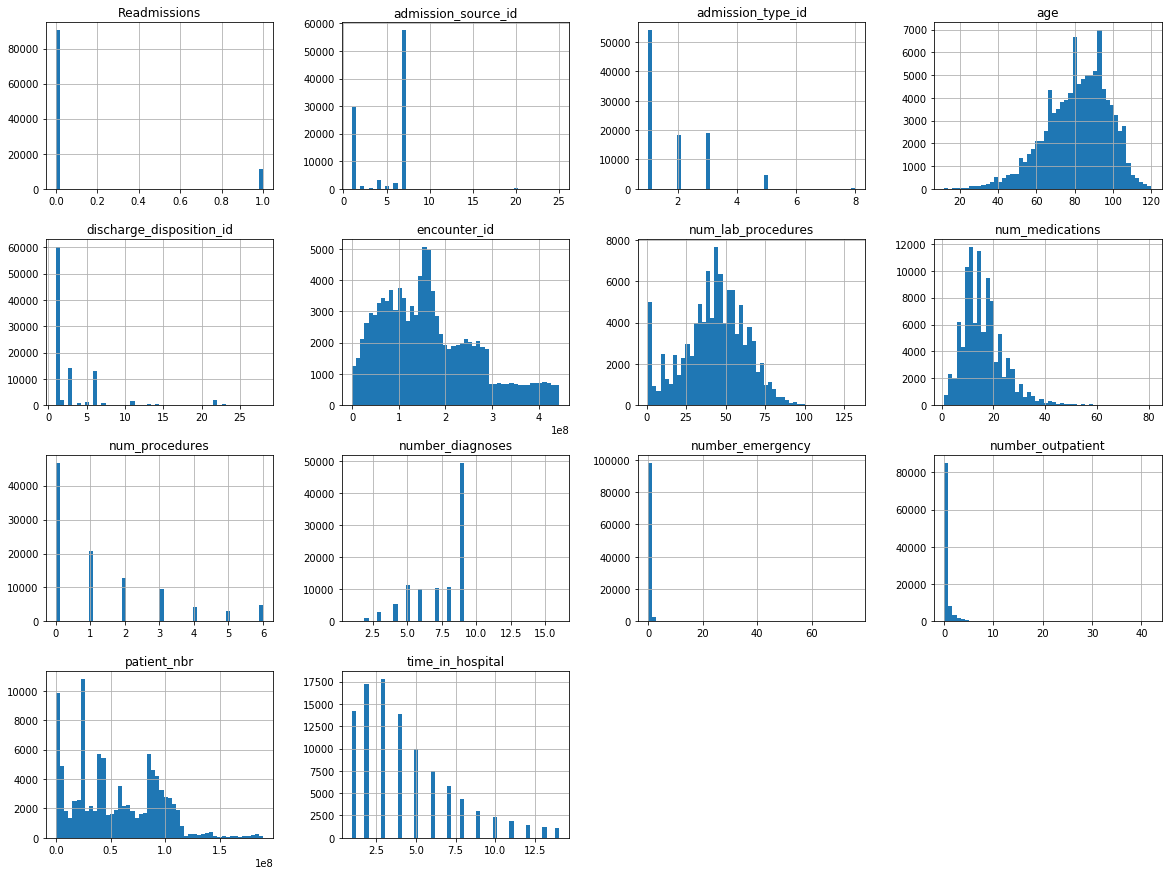

In [0]:
ds.hist(bins=50, figsize=(20,15))
plt.show()

### Questions to ask:
* There are some patients in the dataset who have been admitted on more than one ocassion. Should such a model be based on observations independent of the patient? I would say here is an opportunity to confirm the occurences.  


### Things of note: 
* Age you have a number of different spikes within the ages of 70,80,85... these may be due to certain checkups 
* time_in_hospital has a pareto distribution (edit: actually this might be more of a normal distribution but heavily skewed) 
* The encounter_id has nothing to do with the distribution as it only the encounter occurence. 
 

## Build a predictive model to identify patients at risk of readmitting within 30 days. Evaluate your model.

In [0]:
# All imported models 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn import linear_model
import sklearn as sk

In [0]:
# Removing certain features to use high signal information  (using the above function)
diabetes_ds_test = diabetes_ds
ds = remove_features(diabetes_ds_test, 0.5)


# Identify categorical features and convert to factors using LabelEncoder
object_df = ds.select_dtypes(include=['object']).copy()
object_df = object_df.replace(np.nan, "NaN")

lb_make = LabelEncoder()
for col in object_df.columns:
  object_df[col] = lb_make.fit_transform(object_df[col])

y_pre =  pd.DataFrame(ds['Readmissions'])

int_features = ds.select_dtypes(include=['int64']).copy()
int_features = int_features.drop(['Readmissions'], axis=1)

#Create label encoded features 
trail_data = y_pre.join(object_df)
trail_data = trail_data.join(ds.select_dtypes(include=['float64']).copy()) 
trail_data = trail_data.join(int_features) 


# Take and imput the mean 
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(trail_data)
trail_data_inf = imp.transform(trail_data)
trail_data  = pd.DataFrame(trail_data_inf, columns= trail_data.columns.values)

# Drop features that may not be important to the 
trail_data = trail_data.drop(['admit_date','encounter_id','patient_nbr','admission_source_id','examide','citoglipton'], axis=1)

#Create / morph data for model absorption
y = trail_data['Readmissions']
X = trail_data.loc[:,trail_data.columns != 'Readmissions']

# Split data into train and test sets 
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, random_state=0)




## EDA

In [0]:
trail_data.describe()


,Readmissions,race,gender,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_id,discharge_disposition_id,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,0.111599,1.725252,0.462443,8.328921,20.678960,336.864562,277.999843,287.396183,1.983914,1.893383,1.195596,1.015319,1.006928,1.000884,1.050410,0.000010,1.121219,1.101547,0.000226,1.071989,1.062585,1.003066,1.000295,0.000029,0.000393,1.405469,1.006898,0.000128,0.000010,0.000020,0.000010,0.538048,0.770031,1.427520,1.805950,2.955761,81.398552,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,7.422607
std,0.314874,0.963553,0.498649,3.280405,13.573144,160.650511,154.817974,183.119311,0.309922,0.517917,0.435442,0.134652,0.086992,0.031956,0.241057,0.003135,0.364232,0.343916,0.015032,0.271523,0.252738,0.057550,0.020791,0.005429,0.020312,0.838798,0.084414,0.011302,0.003135,0.004433,0.003135,0.498553,0.420815,0.684068,1.105527,3.940302,16.448028,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.933600
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,12.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,0.000000,7.000000,18.000000,259.000000,142.000000,139.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,71.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,6.000000
50%,0.000000,2.000000,0.000000,8.000000,19.000000,298.000000,260.000000,256.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,83.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,8.000000
75%,0.000000,2.000000,1.000000,10.000000,19.000000,435.000000,376.000000,381.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,3.000000,94.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,9.000000
max,1.000000,5.000000,2.000000,17.000000,72.000000,716.000000,748.000000,789.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,3.000000,1.000000,3.000000,3.000000,3.000000,3.000000,1.000000,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,8.000000,28.0000

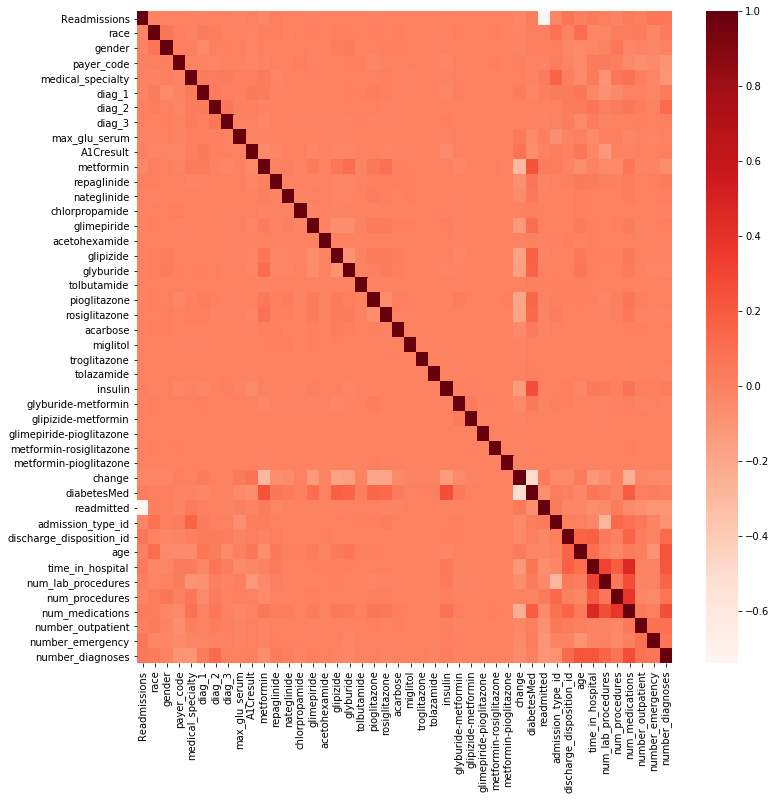

In [0]:
#Pearson Corrrelation understand contributing factors 
import seaborn as sns

#Using Pearson Correlation
plt.figure(figsize=(12,12))
cor = trail_data.corr()
sns.heatmap(cor,  cmap=plt.cm.Reds)
plt.show()


### Correlation Insights 
* You can see that there are some interesting correlations with the feature **diabetesMeds**. **Metformin**, **insulin**, etc. which indicate that they are  medicines taken by diabetic patients. One reason could be  assumed that the correlation is that the likelihood of readmitted patients increase when certain medications have not been taken. 
* **number_diagnoses** does have some correlation with the **diag_2** which probably is due to there being more than 1 diagnosis. 
* **Citoglipton** and **examide** could be drugs taken at the same time (could be procedure or cocktail) since there is a high correlation between these two drugs. It could also be that symtoms seen in these patients are common symptoms seen in diabetic patients. On second thought, the **discharge_disposition_id**, **admission_source_id**, **examide**, and **citoglipton** seem to be very similar to each other. There could be an issue from a data integrity perspective that may be deemed as an error in the inputation. 

## Model 1 (Logistic Regression)

In [0]:
# Model 1 (Logistic Regression)
clf = LogisticRegression(random_state = 0).fit(X_train,y_train)
clf_predictions = clf.predict(X_test)


# The mean squared error
print('Mean squared error: %.2f'  % mean_squared_error(y_test, clf_predictions))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, clf_predictions))



Mean squared error: 0.03
Coefficient of determination: 0.72


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Here we are getting a failed to converge using the LBGFS solver; this can be solved by rescaling some of the features to a little more such as the diag_x features as well as removing some of the features that do not seem to correlate to the rest of the information. 

## Model 2 (Gradient Descent) 

In [0]:
clf_lmsgd = linear_model.SGDClassifier(max_iter=100, tol=1e-3)
clf_lmsgd.fit(X_train,y_train)
clf_predictions_lmsgd = clf_lmsgd.predict(X_test)

# The mean squared error
print('Mean squared error: %.2f'  % mean_squared_error(y_test, clf_predictions_lmsgd))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, clf_predictions_lmsgd))



Mean squared error: 0.01
Coefficient of determination: 0.91


It's always a bit worrisome when a model comes out with mean squared error of almost 0; this seems to be too good to be true. This may be due to the data being generated but this will almost never occur. This you'd want to run as a compilation of data which essentially is boosted trees except runs only once; where the tree is going to run multiple iterations and take the best fit of the data.  

## Model 3 (Boosted Trees) 


In [0]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train,y_train)
clf_predictions_tree= clf_tree.predict(X_test)

# The mean squared error
print('Mean squared error: %.2f'  % mean_squared_error(y_test, clf_predictions_tree))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, clf_predictions_tree))


Mean squared error: 0.00
Coefficient of determination: 1.00


[Text(167.4, 163.07999999999998, 'X[32] <= 0.5\ngini = 0.199\nsamples = 25442\nvalue = [22593, 2849]'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 2849\nvalue = [0, 2849]'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 22593\nvalue = [22593, 0]')]

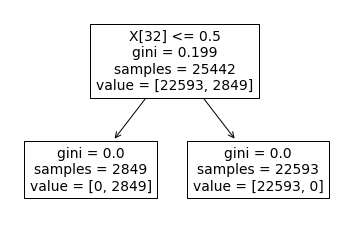

In [0]:
tree.plot_tree(clf_tree.fit(X_test,y_test)) 

# Part 3: Communicate Findings 

## The business owner you are partnering with asks for an update on the project. What do you tell her?


Some of the insights I have spread out across each of the models to ensure better flow of this information. But I would come to say: 

Currently we have created a preliminary model that has an R^2 of 1 based on the dataset that has been given. This essentially means that the model accurately predicted the test cases almost all of the time. 

This is very suspect as there is never a model that is 100% accurate and would lead me to believe that there is either an error or the model is overfitted (i.e. too biased for the dataset and won't be very useful without more data to confirm the models). 

I'd also take the opportunity to ask her any outstanding questions as have been outlined in the above. 

* I'd also want to confirm the insights seen within the data (See above in the EDA section)
* What is the data sources? 
* What are the error limits for the devices (specifically readings that are real time) 

## Insights / Next Steps 
There are a number of other things that you may want try out but due to time to spend I've cut it off here and decided to identify other significant pieces of the puzzle. 

* Date stamp, feature engineer day, month, and year into the data 
* Eliminate some of the other features that don't correlate and rerun the models to see what their difference makes 
*  I'd setup a pipeline of this dataset so that I might be able to iterate through more models and ultimately have the ability to create an esemble of the data if need be. (There are other concerns such as compute time, time to run and size that would need to be included in this information). 
  * That will provide a framework by which I can evaluate multiple models as well ensuring that I am able to find the best fit of the information. (Also, as you might prune different features, being able to easily track them is incredibly important and can quickly get away from you if not careful).  
* Deploy a CV strategy to ensure that I do not overfit the model 

Now there is a caveat to this as there are fewer readmissions than hospital stays. We must better understand these true readmissions and what is fuelling these readmissions within the dataset. 

## Addendum 

In [0]:
diabetes_ds["time_in_hospital"].plot.hist()

In [0]:
diabetes_ds[diabetes_ds["Readmissions"] == 1]
categorical = [['race','payer_code','medical_specialty','max_glu_serum','A1Cresult','metformin','repaglinide','' ]]

In [0]:
diabetes_ds[]